In [6]:
"""
Basic settings...
"""

# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2

import os, time
# select GPU for training
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# import tensorflow.experimental.numpy as np
import numpy as np
import tensorflow as tf
import random
import scipy.io as scio
import h5py 
import math
import sys
sys.path.append("../../")
import lib
from lib.proc import *
from lib.simu import *
from lib.commons import *
from lib.net import *
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat

# gpu memory
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
"""
dataset setting
"""
LENGTH = 130
prefix = "Simulation_Train_Simulation_Valid_len%s_tofts_kvloss_noAIFnoise_breast_linear_ELU_corr_dim_smaller_ve_lim_ve_L1_MPAE_retrain_transformer_dense_standardTofts_fast_checkdata_relusigmoid"%(str(LENGTH))
# previously (180,3) need (3,)
ISTRAIN = True
sample_pattern = 'RES01'
# parameters to set
DCE_DIM = LENGTH

OUT_DIM = 3
IN_DIM = LENGTH

BATCH_SIZE = 64 # 
LR_RATE = 1e-3

BUFFER_SIZE = 8*BATCH_SIZE  # buffer size for shuffle
N_EPOCHS = 100
CKPT_PERIOD = 1

LAYER_NUM = 4
FEATURE_NUM = 64

SIM_SIZE = np.int32(1e+6)
VAL_SIZE = np.int32(1e+4)
hct=0.4

print(prefix)

Simulation_Train_Simulation_Valid_len130_tofts_kvloss_noAIFnoise_breast_linear_ELU_corr_dim_smaller_ve_lim_ve_L1_MPAE_retrain_transformer_dense_standardTofts_fast_checkdata_relusigmoid


In [8]:
# ----------- functions for image processing ----------- 
def normalize_case_zscore(image):
   
    ind = np.nonzero(image)
    image_nonzero = image[ind]
    norm_image = (image - np.mean(image_nonzero)) / np.std(image_nonzero)
    return norm_image

def normalize_case_mean(image, mask):
    mask_img = image*mask
    ind = np.nonzero(mask_img)
    image_nonzero = mask_img[ind]
    norm_image = image / np.mean(image_nonzero) # normalization by dividing the mean value
    return norm_image

# dividing by 95 percentile slice by slice
def normalize_slc_95prc(image):
    ind = np.nonzero(image)
    image_nonzero = image[ind]
    norm_image = image / np.percentile(image_nonzero,95) # set background as 0
    return norm_image

def augment(input_img,output_img):
    image = tf.concat([input_img,output_img],2)
    #image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE+60, IMG_SIZE+60) # Add padding
    image = tf.image.random_crop(image, size=[CROP_H, CROP_W, IN_CHANNEL+OUT_CHANNEL]) # Random crop back
    image = tf.image.random_flip_left_right(image) # Random flip left right
    image = tf.image.random_flip_up_down(image) # Random flip up down
    input_img = image[:,:,0:IN_CHANNEL]
    output_img = image[:,:,IN_CHANNEL:IN_CHANNEL+OUT_CHANNEL]
    return input_img,output_img

def complex_mean(input_img,axis): #specificly for mat file
    mean = np.mean(input_img['real'],axis=axis) + 1j * np.mean(input_img['imag'].astype(np.float32),axis=axis)
    return mean

# loss function
def SSIM_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, tf.math.reduce_max(y_true)-tf.math.reduce_min(y_true)))

def L1_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.abs(y_true - y_pred))

def Mixed_loss(y_true, y_pred):
    return L1_loss(y_true, y_pred) + 0.1*SSIM_loss(y_true, y_pred)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nrmse(predictions, targets):
    return rmse(predictions, targets)/targets.mean()

In [9]:
# ---------- define tool ...
def shuffle_x_y(array1,array2):
    shuffler = np.random.permutation(np.shape(array1)[0])
    array1_shuffled = array1[shuffler]
    array2_shuffled = array2[shuffler]
    return array1_shuffled,array2_shuffled
def gen_series():
    for __x, __y in  zip(X_train, Y_train):
        yield __x, __y
        
def con_2cxm_constant(A,t,alpha1,alpha2,tau1,tau2):
    return A*(alpha1*np.exp(-t/tau1)+alpha2*(np.exp(-t/tau2)))
def con_tofts(del_t, n, c_1, c_2,c_3,vp,ve,ktr):
    c = np.concatenate((c_2,c_3),axis=-1)
    c_new = (vp*c+ktr*np.exp(-ktr/ve*n*del_t)*np.cumsum(c*len_tofts(ktr,ve,n,del_t))*del_t)
    return np.concatenate((c_1,c_new),axis=-1)
def len_tofts (ktr,ve,n,del_t):
    return np.exp(ktr/ve*n*del_t)

def con_tofts_fit_2(c,vp,ve,ktr,del_t):
    """
    input: c (N_pixel,N_temporal),vp,ve,ktr(N_pixel,1)
    output: c_new (N_pixel,N_temporal)
    """
    n = np.array(range(c.shape[-1]))
#     c_new = (vp.reshape(-1,1)*c+
#              (ktr.reshape(-1,1)*np.exp((-ktr/ve).reshape(-1,1).dot(n.reshape(1,-1))*del_t))*np.cumsum(c*len_tofts(ktr,ve,n,del_t),axis=-1)*del_t)
    inp = np.hstack((c.flatten(),len_tofts(-ktr,ve,n,del_t).flatten()))
    length = c.shape[-1]
    c_new = vp*c+ktr*np.apply_along_axis(lambda m: np.convolve(m[:length],m[length:],  mode='full')[:length], axis=-1, arr=inp)*del_t
    return c_new
def gen_con_bd(N=DCE_DIM,r_st_ran=(10,20),r_t_ran=(10,16),A_ran=(3,5),tau1_ran=(20,40),tau2_ran=(800,1200),
           alpha1=0.5,alpha2=0.5): 
    """
    Inputs:
    - N: total time point, default 360
    Random variables:
    - r_st: rising start point
    - r_t : rising duration 
    - A: random scale 
    - tau1, tau2, alpha1, alpha2: parameters in two compartment exchange model
    Outputs:
    - A random generated AIF signal(SI) with shape(N,1)
    """
    A = np.random.uniform(low=A_ran[0],high=A_ran[1])
    r_st = np.random.randint(r_st_ran[0],r_st_ran[1])
    r_t = np.random.randint(r_t_ran[0],r_t_ran[1])
    tau1 = np.random.uniform(low=tau1_ran[0],high=tau1_ran[1])
    tau2 = np.random.uniform(low=tau2_ran[0],high=tau2_ran[1])
    t = np.arange(start=r_st+r_t,stop=N)-(r_st+r_t)+1
    c_1 = np.zeros(r_st) #first stage: pre-injection
    c_2 = A*np.linspace(0,1,num=r_t,axis=-1) #second stage: rising
    c_3 = con_2cxm_constant(A,t,alpha1,alpha2,tau1,tau2) #third stage: perfusion
    return np.concatenate((c_1,c_2,c_3),axis=-1)/(1-hct), c_1/(1-hct),c_2/(1-hct),c_3/(1-hct)

# def get_random_kinetic_uniform(Ft=1.0/60,Fr=0.1/60,vpt=0.2,vpr=0.05,vet=0.2,ver=0.4,PSt=0.08/60,PSr=0.03/60,size=None):
#     """
#     Two compartment exchange model
#     """
#     F = np.random.uniform(low=np.minimum(Ft,Fr),high=np.maximum(Ft,Fr),size=size)
#     vp = np.random.uniform(low=np.minimum(vpt,vpr),high=np.maximum(vpt,vpr),size=size)    
#     ve = np.random.uniform(low=np.minimum(vet,ver),high=np.maximum(vet,ver),size=size)
#     PS = np.random.uniform(low=np.minimum(PSt,PSr),high=np.maximum(PSt,PSr),size=size)
#     return F,vp,ve,PS
# def get_interm_variable(F,vp,ve,PS):
#     """
#     Two compartment exchange model
#     """
#     Te = ve/PS
#     T = (vp+ve)/F
#     Tc = vp/F
#     alpha = ( (T+Te)+np.sqrt((T+Te)**2-4*Tc*Te) )/( 2*Tc*Te )
#     beta  = ( (T+Te)-np.sqrt((T+Te)**2-4*Tc*Te) )/( 2*Tc*Te )
#     A = PS * ( vp*Te*alpha - vp - ve )/((alpha-beta) * vp * ve)
#     ktr = PS * F/(PS+F)
#     return A,ktr,alpha,beta
# def get_random_kinetic_uniform(vpt=0.01,vpr=0.6,vet=0.1,ver=0.8,ktrt=0.002,ktrr=0.2,size=None): #vet 0.2 ver 0.4
#     """
#     Tofts model
#     """
#     vp = np.random.uniform(low=np.minimum(vpt,vpr),high=np.maximum(vpt,vpr),size=size)    
#     ve = np.random.uniform(low=np.minimum(vet,ver),high=np.maximum(vet,ver),size=size)
#     ktr = np.random.uniform(low=np.minimum(ktrt,ktrr),high=np.maximum(ktrt,ktrr),size=size)
#     return vp,ve,ktr
# def get_random_kinetic_uniform(vpt=1e-3,vpr=0.3,vet=0.05,ver=1,ktrt=1e-3,ktrr=0.5,size=None): #vet 0.2 ver 0.4
def get_random_kinetic_uniform(vpt=0.01, vpr=0.6, vet=0.1, ver=0.8, ktrt=0.002, ktrr=0.2, kept=0.001, kepr=0.4, size=None): 
    while True:
        vp = np.random.uniform(low=np.minimum(vpt, vpr), high=np.maximum(vpt, vpr), size=size)    
        ve = np.random.uniform(low=np.minimum(vet, ver), high=np.maximum(vet, ver), size=size)
        ktr = np.random.uniform(low=np.minimum(ktrt, ktrr), high=np.maximum(ktrt, ktrr), size=size)
        kep = ktr / ve

        kep_low, kep_high = np.minimum(kept, kepr), np.maximum(kept, kepr)

        if isinstance(kep, np.ndarray): # If kep is an array
            if np.all((kep >= kep_low) & (kep <= kep_high)): 
                return vp, ve, ktr
        else: # If kep is a scalar
            if kep_low <= kep <= kep_high:
                return vp, ve, ktr

def get_random_R1(T1t=1.600,T1r=0.800,T1bd_min=1.500,T1bd_max=1.600,size=None):# blood 1.4 ~ 2 tissue 1.5 0.8
    T1 = np.random.uniform(low=np.minimum(T1t,T1r),high=np.maximum(T1t,T1r),size=size)
    R1 = 1/T1
    T1_bd = np.random.uniform(low=T1bd_min,high=T1bd_max,size=size)
    R1_bd = 1/T1_bd 
    return R1,R1_bd

def gen_dyna_R1(R1,R1_bd,con_bd,con_pan,r=3.2,N_ds=4):
    # generate dynamic R1,
    # then downsample concentration curve to 4 times long squence
    R1_bd_ = R1_bd+r*con_bd
    R1_pan_ = R1+r*con_pan
    length = len(con_bd)
    R1_bd__ = np.interp(np.arange(0,length*N_ds,1),np.arange(0,length*N_ds,N_ds),R1_bd_)
    R1_pan__ = np.interp(np.arange(0,length*N_ds,1),np.arange(0,length*N_ds,N_ds),R1_pan_)
    return R1_pan__, R1_bd__
def e1(R1,ES=5.6e-3):
    # small TR T1 decay
    return np.exp(-ES*R1)
def Mss(R1,alpha=10*math.pi/180.0):
    return(1-e1(R1))/(1-np.cos(alpha)*e1(R1))*np.sin(alpha)
def S_mul_task(R1,Nseg=84,alpha=10*math.pi/180.0):
    N=np.arange(Nseg).reshape(-1,1)
    S = (Mss(R1=R1,alpha=alpha)*(1-((e1(R1)*np.cos(alpha))**N))).transpose()
    return S
def gen_noise(S,snr=20):
    noise_var = np.sum(S**2)/np.prod(S.shape)/(10**(snr/10))
    noise = np.random.normal(0, np.sqrt(noise_var), S.shape)
    Sn = S + noise
    return Sn
def gen_U0(S_bd,S_pan,cPinv):
    """
    Processing blood and tissue signal to deep-learning-able data format
    Inputs:
    - S_bd: multitasking signal of blood, shape (DCE_DIM,SR_DIM) typically (360,84)
    - S_pan: multitasking signal of tissue, same shape of S_bd
    - cPinv: pseudo-inverse of curvePhi: T1 basis function, generated in matlab, loaded, shape(SR_DIM,cL), typically (84,5)
    Outpus:
    - U0: Input of network. shape (DCE_DIM, 2*cL)
    """
    
    """
    Step1: Shrink SR dimension to cL
    """
    S_bd_0 = np.dot(S_bd,cPinv)
    S_pan_0 = np.dot(S_pan,cPinv)
    """
    Step2: Dealing with complex value
    Note in simulation we all have real value, so neglect this step
    """
    """
    Step3: Scaling (pixel-wise)
    Note in vivo data we use all-image to normalize, so slightly different
    """
    cw = np.amax(S_pan_0)
    scale = np.array([2,50,75,180,210])
    U0 = np.concatenate((S_bd_0*scale, S_pan_0*scale), axis=-1)/cw # scale 2.06590759  64.79525627  74.14727259 183.44910667 210.82790066
    return U0
# %     U0 = cat(4,2*U0(:,:,:,1),3*13*U0(:,:,:,2),2*2*40*U0(:,:,:,3),-3*3*150*U0(:,:,:,4),...
# %         3*3*200*U0(:,:,:,5),-2*1.7*130*U0(:,:,:,7),-2*1.7*400*U0(:,:,:,8),2*1300*U0(:,:,:,9),...
# %         -2*2000*U0(:,:,:,10));
# %     U0_image = permute(U0,[1,2,4,3]);

def gen_simulation_2cxm():
    """
    Goal: randomly generate a simulation pixel
    "Output: 
    """
    F,vp,ve,PS = get_random_kinetic_uniform()
    A,ktr,alpha,beta = get_interm_variable(F,vp,ve,PS)
    R1,R1_bd = get_random_R1()
    con_bd, c_1, c_2, c_3 = gen_con_bd()
    con_pan = con_tofts(del_t=2, n=len(c_2)+len(c_3), c_2=c_2,c_3=c_3, A=A, alpha=alpha, beta=beta)
    S_pan = S_mul_task()
    S_bd = S_mul_task()
    S_bd_n = gen_noise()
    S_pan_n = gen_noise()
    U0 = gen_U0(np.concatenate())
    return U0, (F,vp,ve,PS)

cPinv = scio.loadmat('/home/chaowei/sharedrive/Chaowei/DCE-DL/curvePhi.mat')['curvePhi']

def gen_simulation_tofts():
    """
    Goal: randomly generate a simulation pixel
    "Output: 
    """
    vp,ve,ktr = get_random_kinetic_uniform()
    kep = ktr/ve
    vp=0
    R1,R1_bd = get_random_R1()
    con_bd, c_1, c_2, c_3 = gen_con_bd()
    con_pan = con_tofts_fit_2(con_bd,vp,ve,ktr,del_t=2)
#     con_pan = con_tofts(del_t=2.8,n=np.arange(1,1+len(c_2)+len(c_3)),c_1=c_1, c_2=c_2,c_3=c_3, vp=vp,ve=ve,ktr=ktr)
#     R1_,R1_bd_ = gen_dyna_R1(R1,R1_bd,con_bd,con_pan,N_ds=1) #dynamic R1 and downsample
#     S_pan = S_mul_task(R1_)
#     S_bd = S_mul_task(R1_bd_)
#     S_bd_n = gen_noise(S_bd)
#     S_pan_n = gen_noise(S_pan)
#     U0 = gen_U0(S_bd_n,S_pan_n,cPinv)
#     con_bd = gen_noise(con_bd)
    con_pan = gen_noise(con_pan)
    return {'AIF':con_bd,'Tissue':con_pan},{'KV':np.array([kep,ve,ktr])}
def gen_series():
    for i in range(SIM_SIZE): 
        yield gen_simulation_tofts()
        
def gen_series_val():
    for i in range(VAL_SIZE): 
        yield gen_simulation_tofts()

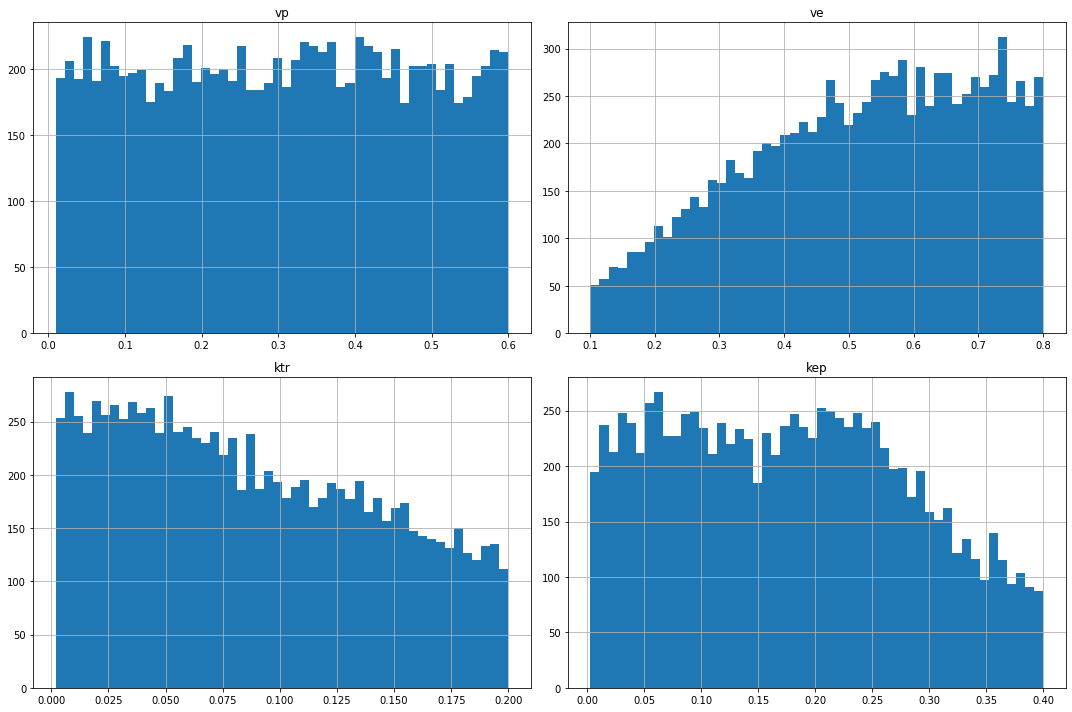

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Generate 10000 parameter sets
num_samples = 10000
data = []
for _ in range(num_samples):
    vp, ve, ktr = get_random_kinetic_uniform()
    data.append([vp, ve, ktr, ktr/ve])

# Convert to a DataFrame for convenience
df = pd.DataFrame(data, columns=['vp', 've', 'ktr', 'kep'])

# Plot histograms
df.hist(bins=50, figsize=(15,10))
plt.tight_layout()
plt.show()

In [6]:
# construct simulation dataset
# train_ds = tf.data.Dataset.from_generator(gen_simulation_tofts,output_types=(tf.float32, tf.float32),
#                                          output_shapes=((DCE_DIM,SR_DIM*2), (OUT_DIM)))
train_ds = tf.data.Dataset.from_generator(gen_series,output_types=({"AIF":tf.float32,'Tissue':tf.float32},{'KV':tf.float32}),
                                         output_shapes=({"AIF":(DCE_DIM),"Tissue":(DCE_DIM)},{"KV":(OUT_DIM)}))

train_ds = (
    train_ds
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

valid_ds = tf.data.Dataset.from_generator(gen_series_val,output_types=({"AIF":tf.float32,'Tissue':tf.float32},{'KV':tf.float32}),
                                         output_shapes=({"AIF":(DCE_DIM),"Tissue":(DCE_DIM)},{"KV":(OUT_DIM)}))
valid_ds = valid_ds.batch(BATCH_SIZE).take(VAL_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# number of steps per epoch
N_STEPS = SIM_SIZE/BATCH_SIZE

In [10]:
"""
model definition
"""
from tensorflow import keras
from tensorflow.keras import layers

def fake_loss(x,y):
    return 1e-10
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError

# Custom mixed loss function
def mixed_loss(y_true, y_pred, alpha=0.5):
    l1_loss = MeanAbsoluteError()(y_true, y_pred)
    mape_loss = MeanAbsolutePercentageError()(y_true, y_pred)
    
    # Combine the two losses with a weight factor (alpha)
    return alpha * l1_loss + (1 - alpha) * mape_loss

# Create a custom loss function with specific alpha
def custom_mixed_loss(alpha):
    def loss(y_true, y_pred):
        return mixed_loss(y_true, y_pred, alpha)
    return loss

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

embed_dim = 64
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
transformer_layer = 4
transformer_blocks = []
    
# ----------- construct model -----------
import datetime
from tensorflow.keras.regularizers import l2
tis_inp = tf.keras.Input(shape=(IN_DIM), name="Tissue")
f_bd = tf.keras.Input(shape=(IN_DIM), name="AIF")

with tf.name_scope("concat2"):
    x2 = tf.expand_dims(tis_inp,axis=-1)
    x3 = tf.expand_dims(f_bd,axis=-1)
    x = tf.keras.layers.Concatenate(axis=-1)([x2, x3])
    x = tf.keras.layers.Dense(embed_dim)(x)

with tf.name_scope("deconv"):
    for i in range(transformer_layer):
        transformer_blocks.append(TransformerBlock(embed_dim, num_heads, ff_dim))
        x = transformer_blocks[i](x)


with tf.name_scope("pred"): 
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    p_kv = tf.keras.layers.Dense(units=OUT_DIM,activation='sigmoid',name="KV")(x)

#     f_pd = con_tofts_tf(f_bd,p_kv[0,0],p_kv[0,1],p_kv[0,2],pad_num=IN_DIM-1)

model = tf.keras.Model(
    inputs=[tis_inp,f_bd], outputs=[p_kv]
)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR_RATE),loss=custom_mixed_loss(0.998))
# model.add_loss(Toftsloss(p_kv,tis_inp,f_bd,reg=1,pad_num=IN_DIM-1))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tissue (InputLayer)             [(None, 130)]        0                                            
__________________________________________________________________________________________________
AIF (InputLayer)                [(None, 130)]        0                                            
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 130, 1)       0           Tissue[0][0]                     
__________________________________________________________________________________________________
tf.expand_dims_1 (TFOpLambda)   (None, 130, 1)       0           AIF[0][0]                        
______________________________________________________________________________________________

Epoch 1/100
1562/1562 [==============================] - 123s 77ms/step - loss: 0.0937 - val_loss: 0.0314

Epoch 00001: saving model to /hdd1/chaowei/dce-dl/checkpoint/Q-kv-ssl-kvloss-sim-noAIFnoise/Simulation_Train_Simulation_Valid_len130_tofts_kvloss_noAIFnoise_breast_linear_ELU_corr_dim_smaller_ve_lim_ve_L1_MPAE_retrain_transformer_dense_standardTofts_fast_checkdata_relusigmoid/cp-0001.ckpt
Epoch 2/100
1562/1562 [==============================] - 119s 76ms/step - loss: 0.0317 - val_loss: 0.0257

Epoch 00002: saving model to /hdd1/chaowei/dce-dl/checkpoint/Q-kv-ssl-kvloss-sim-noAIFnoise/Simulation_Train_Simulation_Valid_len130_tofts_kvloss_noAIFnoise_breast_linear_ELU_corr_dim_smaller_ve_lim_ve_L1_MPAE_retrain_transformer_dense_standardTofts_fast_checkdata_relusigmoid/cp-0002.ckpt
Epoch 3/100
1562/1562 [==============================] - 120s 77ms/step - loss: 0.0279 - val_loss: 0.0334

Epoch 00003: saving model to /hdd1/chaowei/dce-dl/checkpoint/Q-kv-ssl-kvloss-sim-noAIFnoise/Simulat

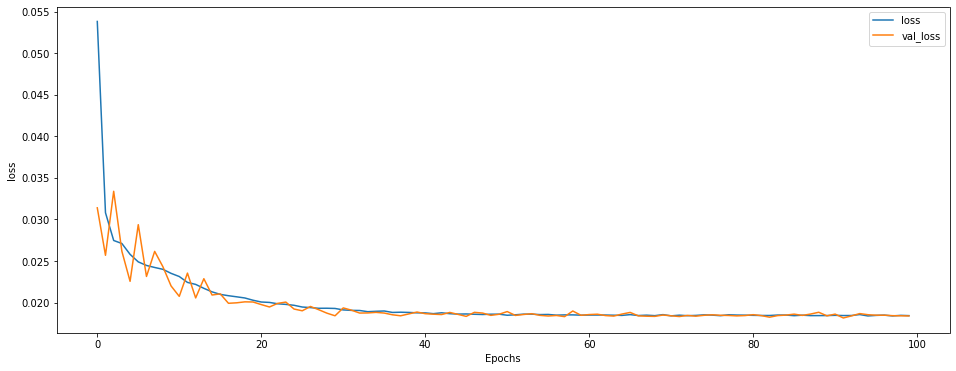

In [11]:
"""
model training 
"""
# ----------- train model -----------
# tensorboard callbck
logdir = os.path.join("/hdd1/chaowei/dce-dl/log/Q-kv-ssl-kvloss-sim-noAIFnoise",prefix, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# save checkpoints
checkpoint_path = os.path.join("/hdd1/chaowei/dce-dl/checkpoint/Q-kv-ssl-kvloss-sim-noAIFnoise",prefix,"cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=CKPT_PERIOD)

# adaptive learning rate
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

if ISTRAIN is True:
    model.trainable = True
    history = model.fit(train_ds,epochs=N_EPOCHS,steps_per_epoch=N_STEPS,validation_data=valid_ds,
                        callbacks = [reduce_lr,tensorboard_callback,cp_callback])

    print("completed")
    
model.trainable = False
model.summary()

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

if ISTRAIN is True:
    plt.figure(figsize=(16,6))
    plot_graphs(history, 'loss')
else: 
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
!bash /home/chaowei/mailsender.sh